In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')

In [15]:
df_restoran = pd.read_excel(r'd:\Работа ВВЮ\DataScience\Final project\Restoran.xlsx')

df_restoran=df_restoran[df_restoran['Время открытия'] > '2021-05-01']

In [16]:
df__sort=df_restoran.sort_values('Время открытия', ascending=[True])

In [35]:
df_daily=df__sort.groupby(pd.Grouper(key='Время открытия', freq='1D')).sum().copy()

[Text(0.5, 0, 'Дата')]

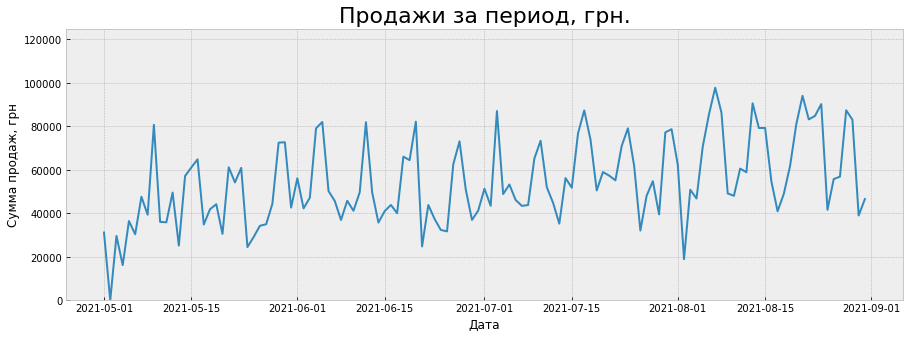

In [24]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(df_daily['Сумма со скидкой, грн.'])

ax.set_title('Продажи за период, грн.', fontdict={'size':22})
ax.set(ylabel='Сумма продаж, грн', ylim=(0, 125000))
ax.set(xlabel='Дата')

In [38]:
df_daily.reset_index(inplace=True)

In [42]:
df_daily['Время открытия'] = pd.to_datetime(df_daily['Время открытия']) 

In [53]:
df_daily[df_daily['Время открытия'] == '2021-05-01']

,Время открытия,Номер чека,Количество блюд,"Сумма со скидкой, грн.","Себестоимость, грн."
0,2021-05-01,9521790,305.02,31170.2,10577.66


In [81]:
data=df_daily[['Время открытия', 'Сумма со скидкой, грн.']].copy()
data=data.rename(columns={'Время открытия': 'Time', 'Сумма со скидкой, грн.': 'Sales'})
data=data.set_index('Time')
data

,Sales
Time,
2021-05-01,31170.20
2021-05-02,0.00
2021-05-03,29629.00
2021-05-04,16174.81
2021-05-05,36439.50
...,...
2021-08-27,56854.90
2021-08-28,87401.50
2021-08-29,83018.00


In [157]:
data_0 = data[data.index > '2021-05-02']

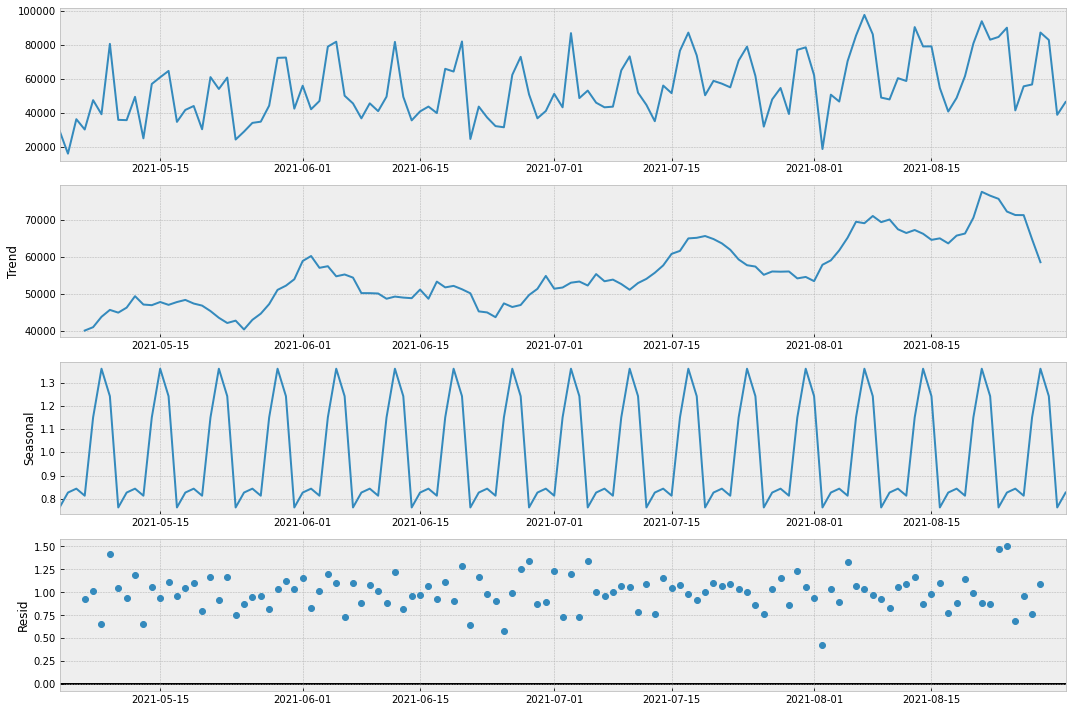

In [162]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (15,10)
result = seasonal_decompose(data_0, model='multiplicative')
result.plot()
plt.show()

### XGBoost

In [82]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [190]:
split_date = '2021-08-01'
train, test = split_data(data_0, split_date)

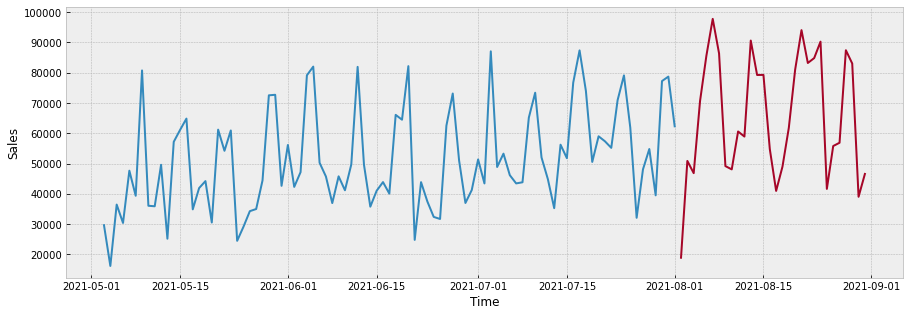

In [191]:

plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [95]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','dayofyear','dayofmonth','weekofyear']]
    return X

In [96]:
X_train, y_train = create_features(train), train['Sales']
X_test, y_test   = create_features(test), test['Sales']

X_train.shape, y_train.shape, X_test.shape, y_test.shape


<ipython-input-95-c0b10f32e311>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


((93, 6), (93,), (30, 6), (30,))

In [93]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [97]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

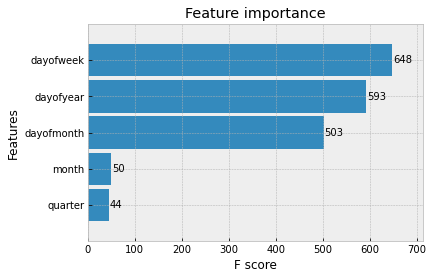

In [98]:
xgb.plot_importance(reg, height=0.9)

In [101]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.plot(data.index,data, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

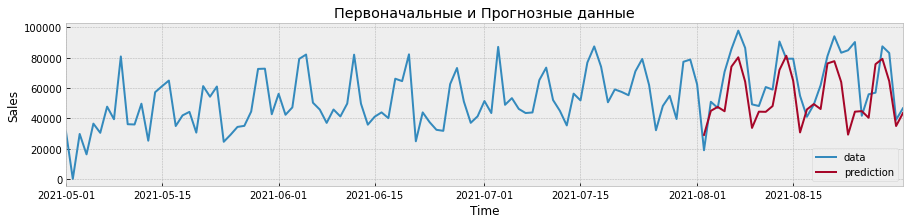

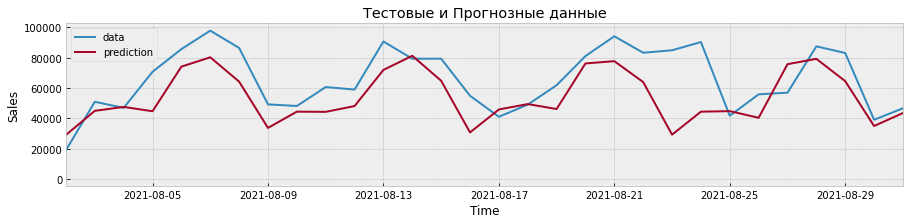

In [104]:
X_test_pred = reg.predict(X_test)
    
plot_performance(data, data.index[0].date(), data.index[-1].date(),
                 'Первоначальные и Прогнозные данные')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Тестовые и Прогнозные данные')

#plot_performance(y_test, '01-08-2021', '01-09-2021', 'Август 2021')

plt.legend()

plt.show()

In [108]:
mean_squared_error(y_true=y_test, y_pred=X_test_pred)

357532689.45363456

In [109]:
mean_absolute_error(y_true=y_test, y_pred=X_test_pred)

14482.897463541665

In [110]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [113]:
print('MAPE =', mean_absolute_percentage_error(y_test,X_test_pred).round(4))

MAPE = 21.6521


### ARIMA

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

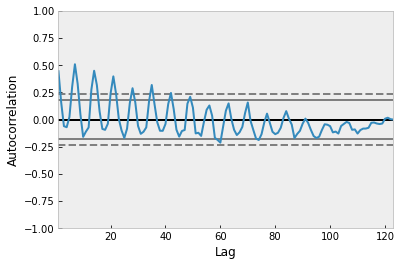

In [115]:
pd.plotting.autocorrelation_plot(data)

In [116]:
from statsmodels.tsa.arima_model import ARIMA

In [150]:
model = ARIMA(data, order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  122
Model:                ARIMA(10, 1, 0)   Log Likelihood               -1338.009
Method:                       css-mle   S.D. of innovations          13794.955
Date:                Sat, 23 Oct 2021   AIC                           2700.018
Time:                        17:14:22   BIC                           2733.666
Sample:                    05-02-2021   HQIC                          2713.685
                         - 08-31-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            276.2665    343.367      0.805      0.421    -396.720     949.253
ar.L1.D.Sales     -0.7025      0.089     -7.872      0.000      -0.877      -0.528
ar.L2.D.Sales     -0.4346      0.122

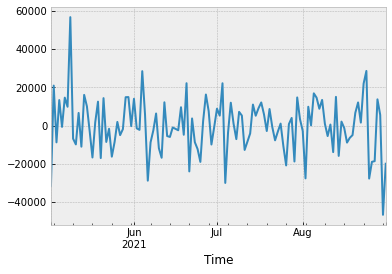

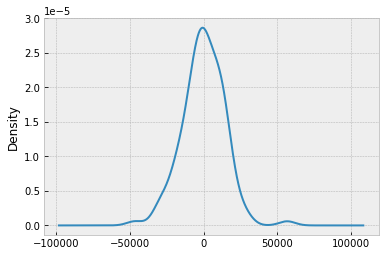

count      122.000000
mean       -93.523861
std      14236.806042
min     -46586.123397
25%      -8515.667169
50%       -422.641984
75%       9519.937065
max      56761.486631
dtype: float64


In [151]:
residuals = model_fit.resid
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=56366.976612, expected=62280.540000
predicted=43518.668820, expected=18893.000000
predicted=41436.462924, expected=50851.000000
predicted=42657.803799, expected=46815.750000
predicted=49195.775779, expected=70622.740000
predicted=69170.513600, expected=85572.500000
predicted=92322.708827, expected=97762.570000
predicted=71514.131197, expected=86347.180000
predicted=51975.143841, expected=49144.750000
predicted=67261.916115, expected=48056.380000
predicted=68443.800766, expected=60571.020000
predicted=81165.644722, expected=58896.090000
predicted=78143.768163, expected=90593.750000
predicted=102003.946678, expected=79228.600000
predicted=72709.812228, expected=79259.500000
predicted=49777.519227, expected=54800.960000
predicted=45435.761384, expected=40948.300000
predicted=51195.142458, expected=48963.470000
predicted=62026.083058, expected=61779.000000
predicted=69345.482692, expected=80991.630000
predicted=79325.020753, expected=94041.500000
predicted=79064.346640, expected=

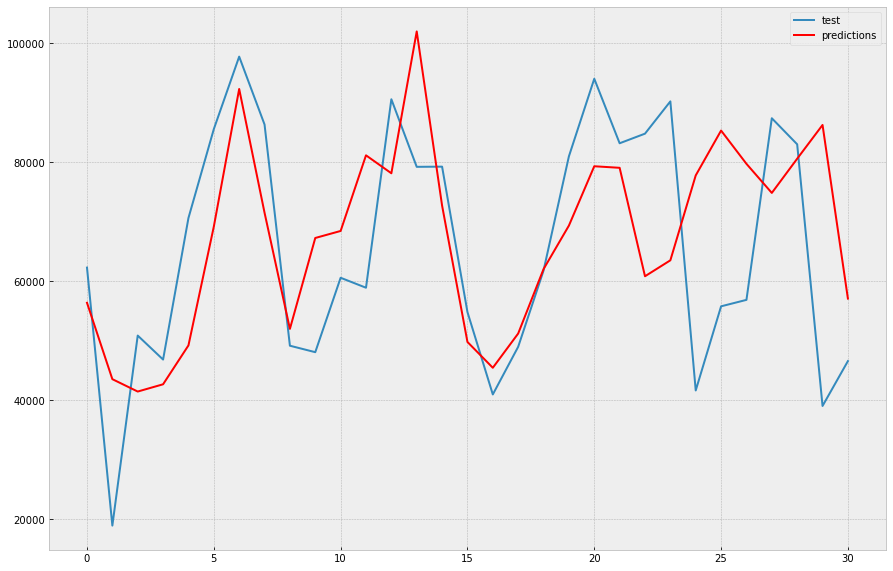

In [192]:
X = data.Sales
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
test1 =[x for x in test]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test1, label = 'test')
plt.plot(predictions, color='red', label = 'predictions')
plt.legend()
plt.show()

### SARIMA

In [168]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [184]:
data = data
my_order = (2, 1, 1)
my_seasonal_order = (1, 1, 1, 7)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order, enforced_stationarity = False, enforce_inveribility = False)
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  123
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1262.708
Date:                           Sat, 23 Oct 2021   AIC                           2537.416
Time:                                   17:46:11   BIC                           2553.886
Sample:                               05-01-2021   HQIC                          2544.101
                                    - 08-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0797      0.278      0.287      0.774      -0.465       0.624
ar.L2          0.2233      0.222      1.007

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


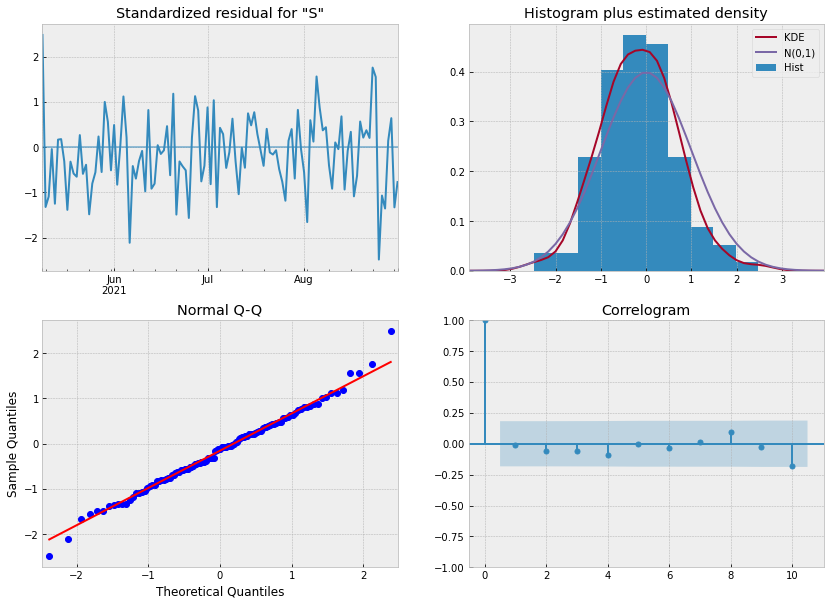

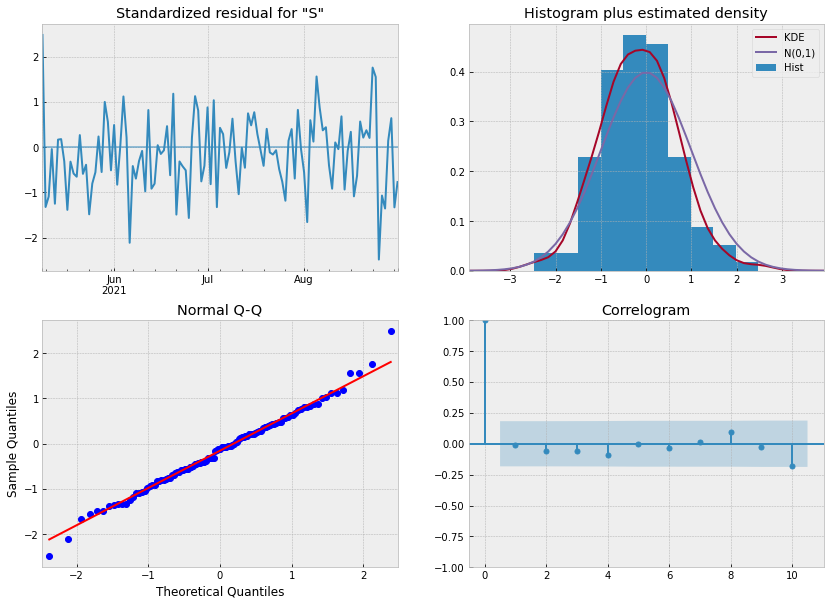

In [185]:
model_fit.plot_diagnostics(figsize=(14,10))

In [187]:
forecast_values = model_fit.get_forecast(steps=30)
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()

Sales,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-01,44287.311011,16148.000124,12637.812346,75936.809676
2021-09-02,50083.856428,16754.981615,17244.695901,82923.016954
2021-09-03,67233.952768,18214.069389,31535.032753,102932.872782
2021-09-04,81750.897269,18822.929170,44858.634012,118643.160526
2021-09-05,73122.141980,19516.080435,34871.327208,111372.956751
2021-09-06,46811.900114,20063.092758,7488.960891,86134.839338
2021-09-07,51071.004055,20607.081865,10681.865773,91460.142338
2021-09-08,48071.242292,22195.642290,4568.582790,91573.901794
2021-09-09,52176.626030,22893.238763,7306.702565,97046.549494
2021-09-10,69487.010859,23715.380701,23005.718804,115968.302913


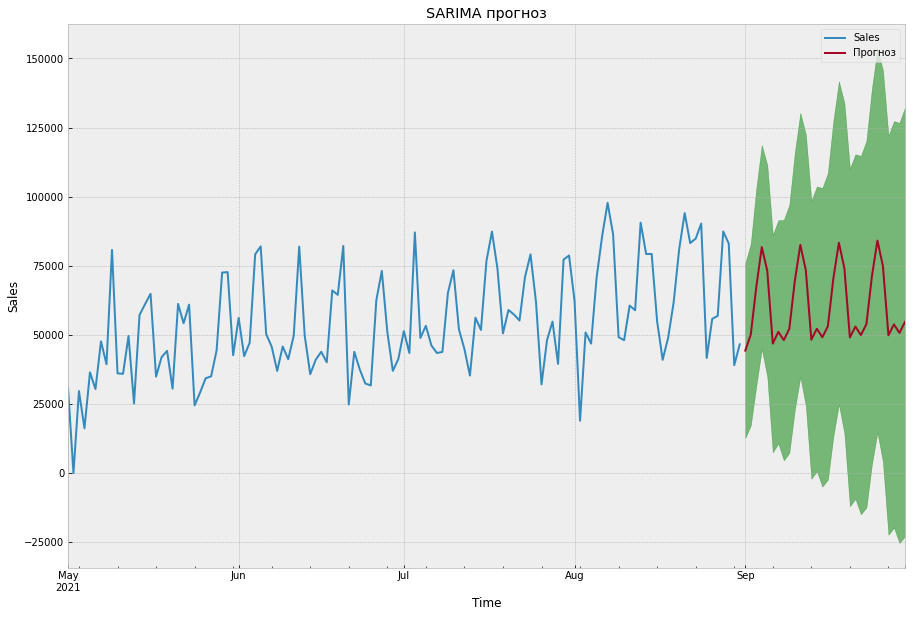

In [189]:
ax = data.plot()

forecast_values.predicted_mean.plot(ax=ax, label = 'Прогноз')

ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color = 'g', alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.set_title('SARIMA прогноз')

plt.legend()

In [ ]:
SARIMA(3,1,0)(1,1,0)12

In [ ]:
yhat = model_fit.forecast()
yhat = model_fit.predict(start=len(data), end=len(data))